In [ ]:
import os,sys
sys.path.append(os.path.abspath(".."))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from core.data import *
from core.utils import exclude,seed_all
import seaborn as sns
# sns.set_theme(style="darkgrid")
seed = 1
palette = sns.palettes.color_palette("bright", as_cmap=True)
sns.set_palette(palette=palette)
seed_all(seed)

In [3]:
movies, ratings = load_ds()
movies, users, movie_cols, user_cols = preprocess(movies, ratings,keep_title=True,keep_genres=True)
(movie_cat_cols, movie_num_cols), (user_cat_cols, user_num_cols) = movie_cols, user_cols

n_users = users.user.nunique()
n_movies = movies.movie.nunique()

In [4]:
all_genres = exclude(movie_cat_cols,"movie","year_bin")
count1 = movies[all_genres].astype(int).sum().values
count2 = movies[all_genres].loc[movies.movie_avg_rating>0].astype(int).sum().values
counts = pd.DataFrame(dict(genre=all_genres,all=count1,positive_rating=count2))
counts.head(1)

,genre,all,positive_rating
0,Comedy,3462,1103


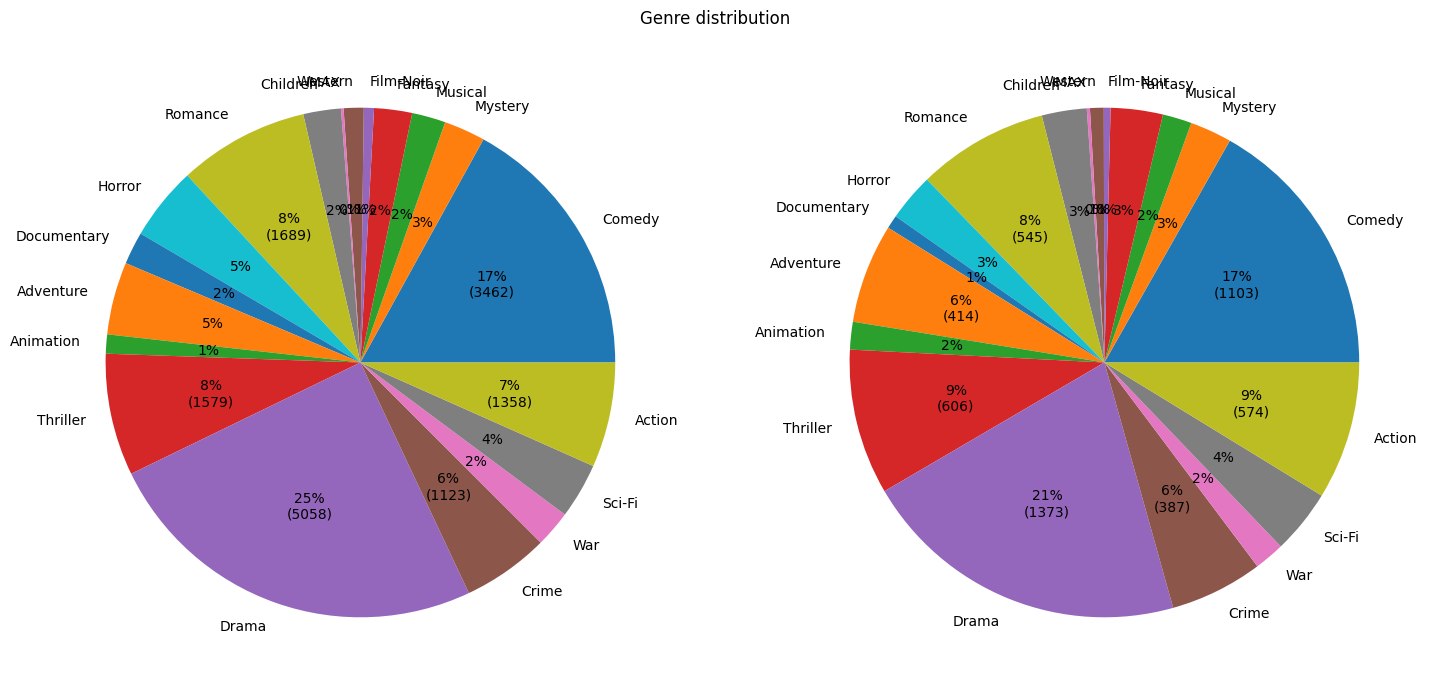

In [5]:
def pie(count,labels,title="",ax=None):
    total = sum(count)
    def my_fmt(x):
        s = f'{x:.0f}%'
        if x>5:
            s += f"\n({total*x/100:.0f})"
        return s
    if ax is None: ax = plt.subplot()
    ax.pie(count, labels=labels, autopct=my_fmt)
    ax.set_title(title)
fig,axes = plt.subplots(1,2,figsize=(15,7))
for i, ax in zip(["all", "positive_rating"], axes):
    pie(counts[i], counts.genre, ax=ax)
fig.suptitle("Genre distribution");
fig.tight_layout()

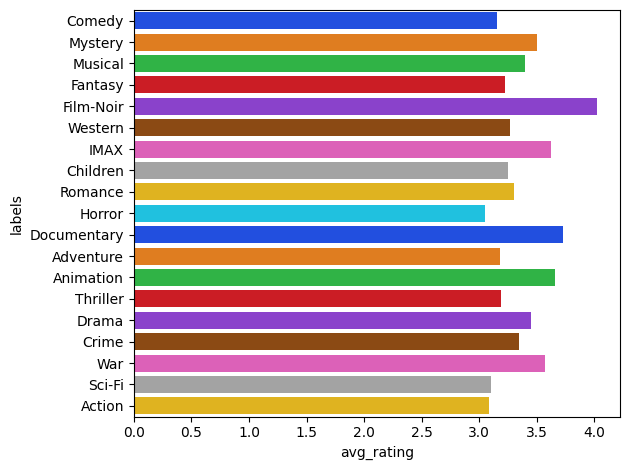

In [6]:
means = [movies.loc[(movies[g] == 1) & (movies.movie_avg_rating>0)].movie_avg_rating.mean() for g in all_genres]
sns.barplot(pd.DataFrame(dict(avg_rating=means, labels=all_genres)),x="avg_rating", y="labels", palette=palette)
plt.tight_layout()

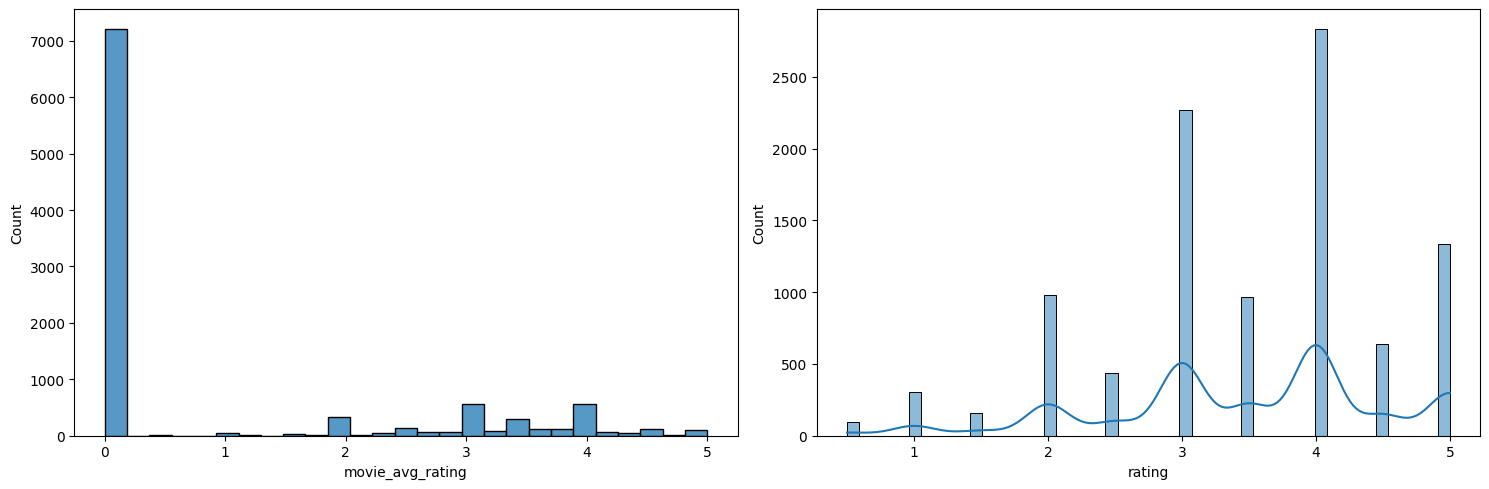

In [7]:
_, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
sns.histplot(data=movies,x="movie_avg_rating",ax=ax1)
sns.histplot(data=ratings, x="rating", kde=True, ax=ax2)
plt.tight_layout()

,is_rated,count
0,False,7204
1,True,2796


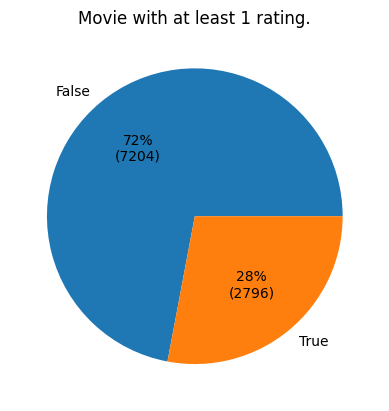

In [8]:
nrated = (movies.movie_avg_rating > 0).rename("is_rated").value_counts().reset_index()
pie(nrated["count"], nrated.is_rated,title="Movie with at least 1 rating.")
nrated

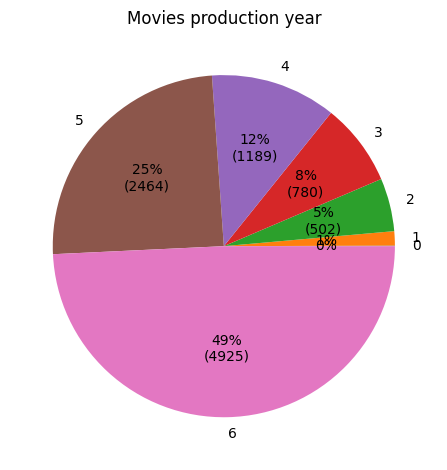

In [9]:
a = movies.year_bin.value_counts().sort_index().reset_index()
pie(a["count"],a.year_bin,"Movies production year")
plt.tight_layout()

In [33]:
movieecols = exclude(movies.columns.tolist(), "__movieId", "title","genres","main_genre")
user_colss = exclude(users.columns.tolist(), "__userId")

In [72]:
from core.suggester import Suggester

suggester = Suggester()
suggester.fit(movies[movieecols], users[user_colss],ratings)
movieIds = suggester.suggest(
    2, 10, add_closest_users=True,
    n_neighbor_users=60, n_neighbor_movies=300,
    deterministic=True,
)
movies.loc[movies.movie.isin(movieIds)]

,movie,title,genres,movie_avg_rating,Comedy,Mystery,Musical,Fantasy,Film-Noir,Western,...,Animation,Thriller,Drama,Crime,War,Sci-Fi,Action,main_genre,year_bin,__movieId
25,25,Othello (1995),Drama,4.000000,False,False,False,False,False,False,...,False,False,True,False,False,False,False,Drama,6,26
31,31,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller,3.895833,False,True,False,False,False,False,...,False,True,False,False,False,True,False,Mystery,6,32
162,162,Devil in a Blue Dress (1995),Crime|Film-Noir|Mystery|Thriller,4.500000,False,True,False,False,True,False,...,False,True,False,True,False,False,False,Crime,6,164
288,288,Outbreak (1995),Action|Drama|Sci-Fi|Thriller,3.153846,False,False,False,False,False,False,...,False,True,True,False,False,True,True,Action,6,292
296,296,Quiz Show (1994),Drama,3.875000,False,False,False,False,False,False,...,False,False,True,False,False,False,False,Drama,6,300
364,364,Mrs. Parker and the Vicious Circle (1994),Drama,4.000000,False,False,False,False,False,False,...,False,False,True,False,False,False,False,Drama,6,369
581,581,Terminator 2: Judgment Day (1991),Action|Sci-Fi,4.000000,False,False,False,False,False,False,...,False,False,False,False,False,True,True,Action,5,589
1183,1183,Alien (1979),Horror|Sci-Fi,3.916667,False,False,False,False,False,False,...,False,False,False,False,False,True,False,Horror,5,1214
1391,1391,Underworld (1996),Comedy|Thriller,3.000000,True,False,False,False,False,False,...,False,True,False,False,False,False,False,Comedy,6,1430
1566,1566,"Game, The (1997)",Drama|Mystery|Thriller,3.400000,False,True,False,False,False,False,...,False,True,True,False,False,False,False,Drama,6,1625
